In [1]:
import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import joblib
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 파이썬 Local O3 학습 모델 로드
model_tf = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/final_model_main_v2')

# C 컴파일링(공유 라이브러리) Local O3 모델 로드
model_c = ctypes.CDLL("/home/user/workdir/CMAQ_Emulator/GreenEco/libo3_model.so")
model_c.call.argtypes = [
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int]
model_c.call.restype = None

# 터이터셋 로드
ctrl_mat = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/nox_voc_datasets.csv', index_col=0)

2025-03-17 11:04:12.189609: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 11:04:12.219360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 11:04:12.219390: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 11:04:12.219410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 11:04:12.225301: I tensorflow/core/platform/cpu_feature_g

In [2]:
batch_size = 3
inputs = ctrl_mat.sample(n=batch_size).values.astype(np.float32)
pred_1 = np.zeros((batch_size, 82, 67, 1)).astype(np.float32)

In [3]:
model_c.call(
    inputs.reshape(-1).ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    pred_1.reshape(-1).ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    batch_size)

In [4]:
pred_0 = model_tf.predict(inputs.reshape(batch_size, 17*2), verbose=0)

scaler = joblib.load('/home/user/workdir/CMAQ_Emulator/GreenEco/scale_parameter.pkl')
n_samples = pred_0.shape[0]  # 테스트 샘플 수
pred_0 = scaler.inverse_transform(pred_0.reshape(n_samples, -1))
pred_0 = pred_0.reshape(n_samples, 82, 67, 1)
pred_1 = scaler.inverse_transform(pred_1.reshape(n_samples, -1))
pred_1 = pred_1.reshape(n_samples, 82, 67, 1)


2025-03-17 11:04:19.374607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


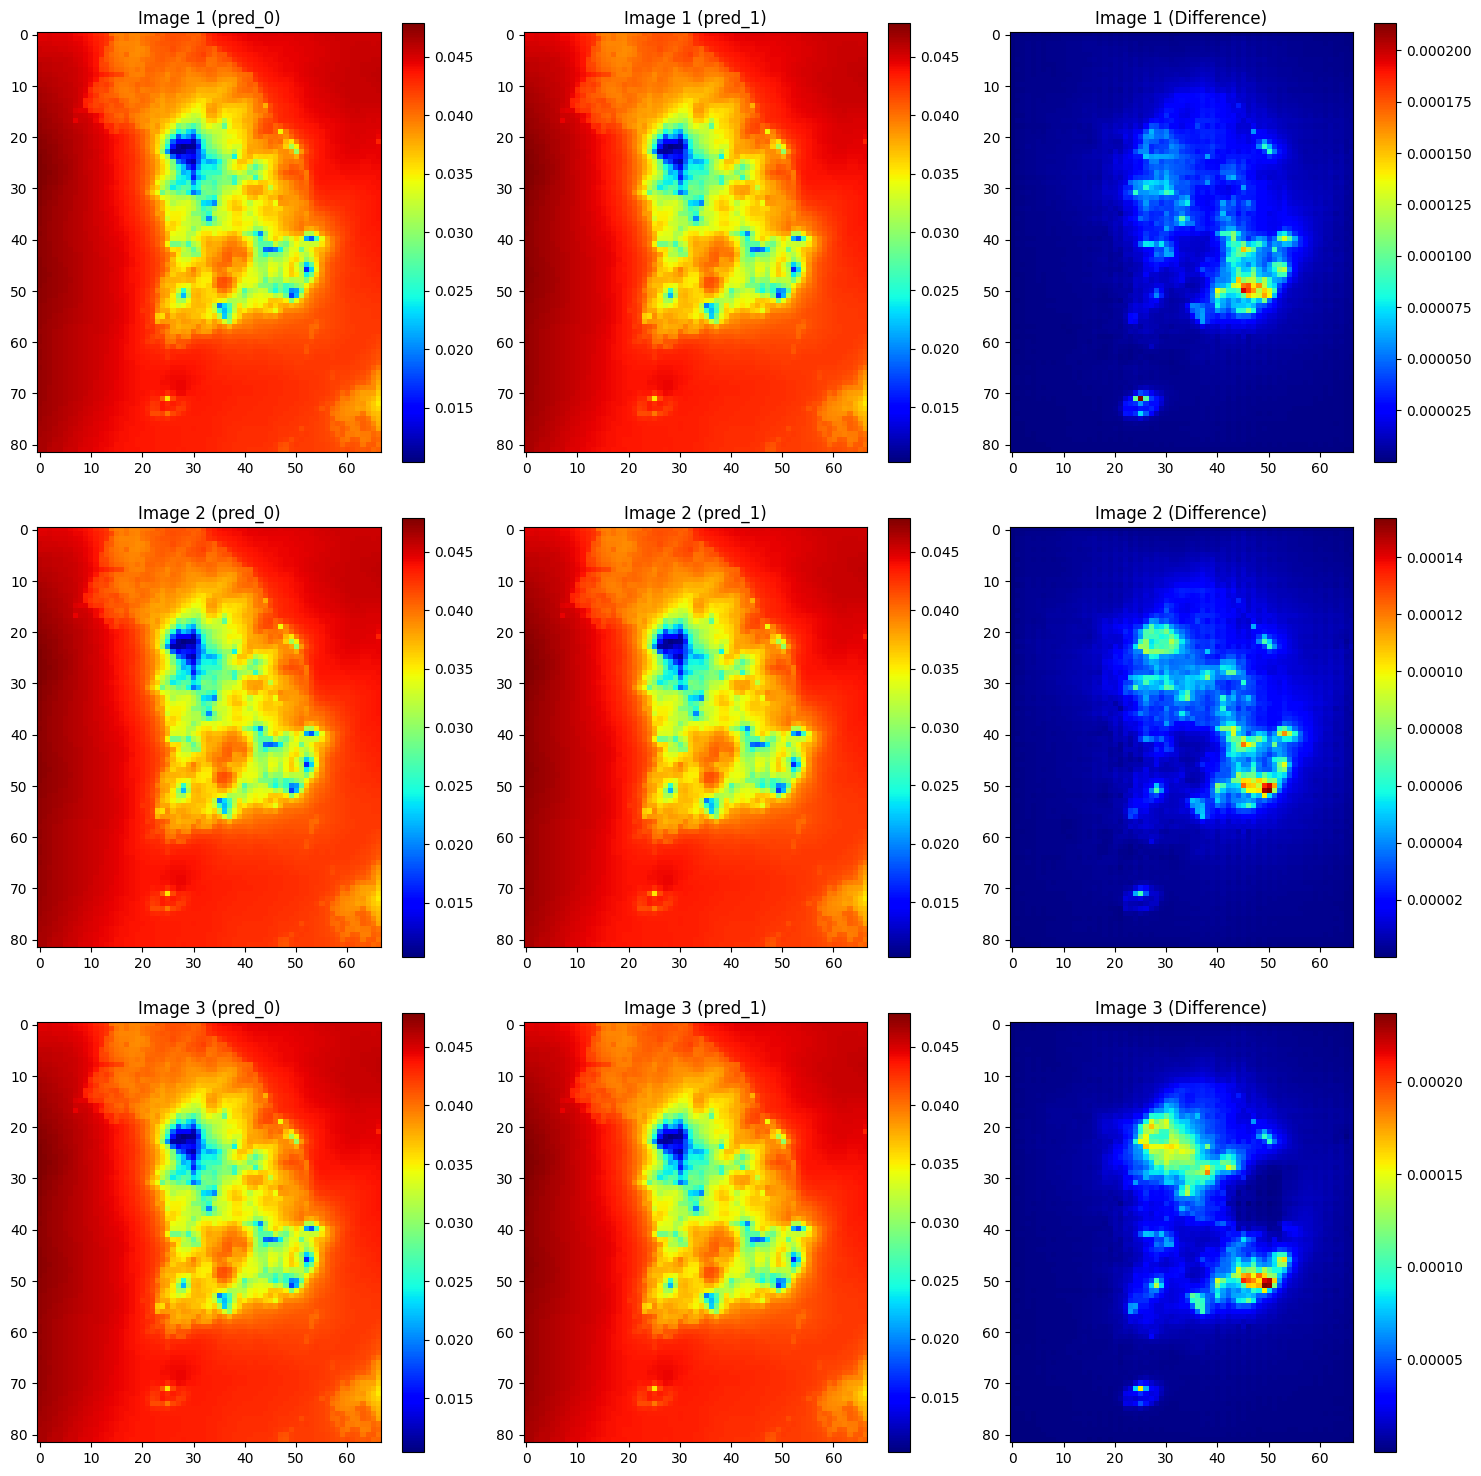

In [5]:
num_images = 3  # pred_0과 pred_1에 저장된 이미지 개수
fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(15, 5 * num_images))

for i in range(num_images):
    # 파이썬 모델의 이미지 시각화
    ax = axes[i, 0]
    im0 = ax.imshow(pred_0[i][::-1], cmap='jet')
    ax.set_title(f'Image {i+1} (pred_0)')
    plt.colorbar(im0, ax=ax)

    # 공유 라이브러리 모델의 이미지 시각화
    ax = axes[i, 1]
    im1 = ax.imshow(pred_1[i][::-1], cmap='jet')
    ax.set_title(f'Image {i+1} (pred_1)')
    plt.colorbar(im1, ax=ax)

    # 두 모델 간 차이 이미지 시각화
    ax = axes[i, 2]
    diff = pred_0[i] - pred_1[i]
    im_diff = ax.imshow(diff[::-1], cmap='jet')
    ax.set_title(f'Image {i+1} (Difference)')
    plt.colorbar(im_diff, ax=ax)

plt.tight_layout()
plt.show()